In [1]:
import os

from glob import glob
from os.path import basename, exists, join
import pandas as pd
from src.config import ROOT_DIR, RESULTS
import pickle
os.chdir(ROOT_DIR)

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from src.external.pyvenn import venn

Project Directory: /data2/mito_lineage


In [2]:
outdir = "data/processed/2020_11_18_Croker_mito"
outdir_cov = join(outdir, "coverage")
if not exists(outdir):
    os.mkdir(outdir)
    
if not exists(outdir_cov):
    os.mkdir(outdir_cov)

In [3]:
samples = pd.read_csv("parameters/2020_11_18_Croker_mito.csv")
samples

,sample,raw,barcode_f,bam_f
0,PBMC_J,NaN,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...
1,PBMC_P,NaN,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...


### Parameters

In [4]:
mapq = 0

## Load barcodes for each sample

In [5]:
from src.utils.parse_config import *
p = read_config_file("parameters/2020_11_18_Croker_mito.yaml")
p

{'samples': 'parameters/2020_11_18_Croker_mito.csv',
 'results': 'data/processed/mttrace/2020_11_18',
 'figures': 'figures/mttrace/2020_11_18',
 'main': ['mtscATAC'],
 'use_cellr_barcode': [False, True],
 'num_reads_filter': [200],
 'mito_character': 'chrM',
 'maxBP': 16571,
 'mapq': [0],
 'ref_fa': '/data2/mito_lineage/data/external/GRCh38_MT_blacklist/fasta/genome.fa',
 'mt_ref_fa': '/data2/mito_lineage/data/external/refdata-cellranger-GRCh38-3.0.0/chrM.fasta',
 'min_cells': [100, 500, 10],
 'min_reads': [100],
 'top_cells': [0],
 'top_pos': [0],
 'cell_mt_coverage': [10, 100],
 'position_bq_thresh': [0, 'Gaussian']}

In [16]:
ls data/processed/mttrace/2020_11_18/PBMC_J/mapq_0/cellr_False/PBMC_J_barcode_data.p

PBMC_J_200/            PBMC_J_CB_coverage_hist_minReads200.dist.png
PBMC_J_barcode_data.p


In [6]:

samples['cellr_barcode_raw_f'] = ""
samples['cellr_barcode_filt_f'] = ""
samples["cb_barcode_f"] = ''
samples["cov_f"] = ''

for ind, val in samples.iterrows():
    bc_f = (os.path.join(os.path.dirname(val['bam_f']),"raw_peak_bc_matrix","barcodes.tsv.gz"))
    samples.at[ind,'cellr_barcode_raw_f'] = (os.path.join(os.path.dirname(val['bam_f']),"raw_peak_bc_matrix","barcodes.tsv"))
    samples.at[ind,'cellr_barcode_filt_f'] = (os.path.join(os.path.dirname(val['bam_f']),"filtered_peak_bc_matrix","barcodes.tsv"))
    samples.at[ind,"cov_f"] =  join(p["results"], val['sample'], f'mapq_{mapq}', 'scPileup_concat_200', val['sample'] + '_200_all.coverage.txt.gz')
    samples.at[ind,"cb_barcode_f"] = join(p["results"], val['sample'], f'mapq_{mapq}',f"{val['sample']}_barcode_data.p")
    fig_dir = join("figures", "mttrace","2020_11_18",  val['sample'],f'mapq_{mapq}')
    if not os.path.exists("figures/mttrace"):
        print("Need to make the figures/mttrace folder in the current directory")
    else:
        if not os.path.exists(fig_dir):
            os.makedirs(fig_dir)
    samples.at[ind,"venn_out_f"] = join(fig_dir, "barcode_overlap.png")
                                              
#raw_bc_matrix = pd.read_csv(bc_f,sep='\t', header=None)
#raw_bc_matrix
samples

,sample,raw,barcode_f,bam_f,cellr_barcode_raw_f,cellr_barcode_filt_f,cb_barcode_f,cov_f,venn_out_f
0,PBMC_J,NaN,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...,data/processed/mttrace/2020_11_18/PBMC_J/mapq_...,data/processed/mttrace/2020_11_18/PBMC_J/mapq_...,figures/mttrace/2020_11_18/PBMC_J/mapq_0/barco...
1,PBMC_P,NaN,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...,/data2/isshamie/mito_lineage/data/processed/mt...,data/processed/mttrace/2020_11_18/PBMC_P/mapq_...,data/processed/mttrace/2020_11_18/PBMC_P/mapq_...,figures/mttrace/2020_11_18/PBMC_P/mapq_0/barco...


(735,)


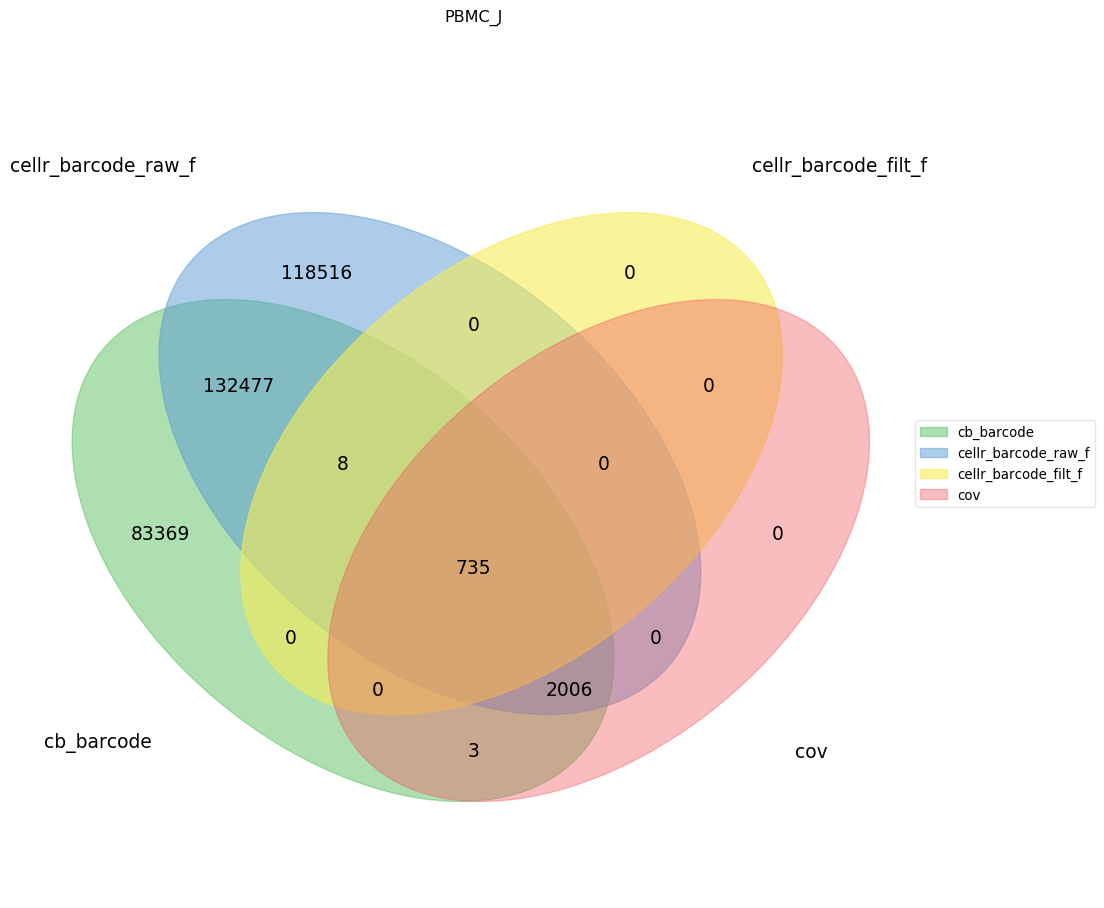

(328,)


<Figure size 432x288 with 0 Axes>

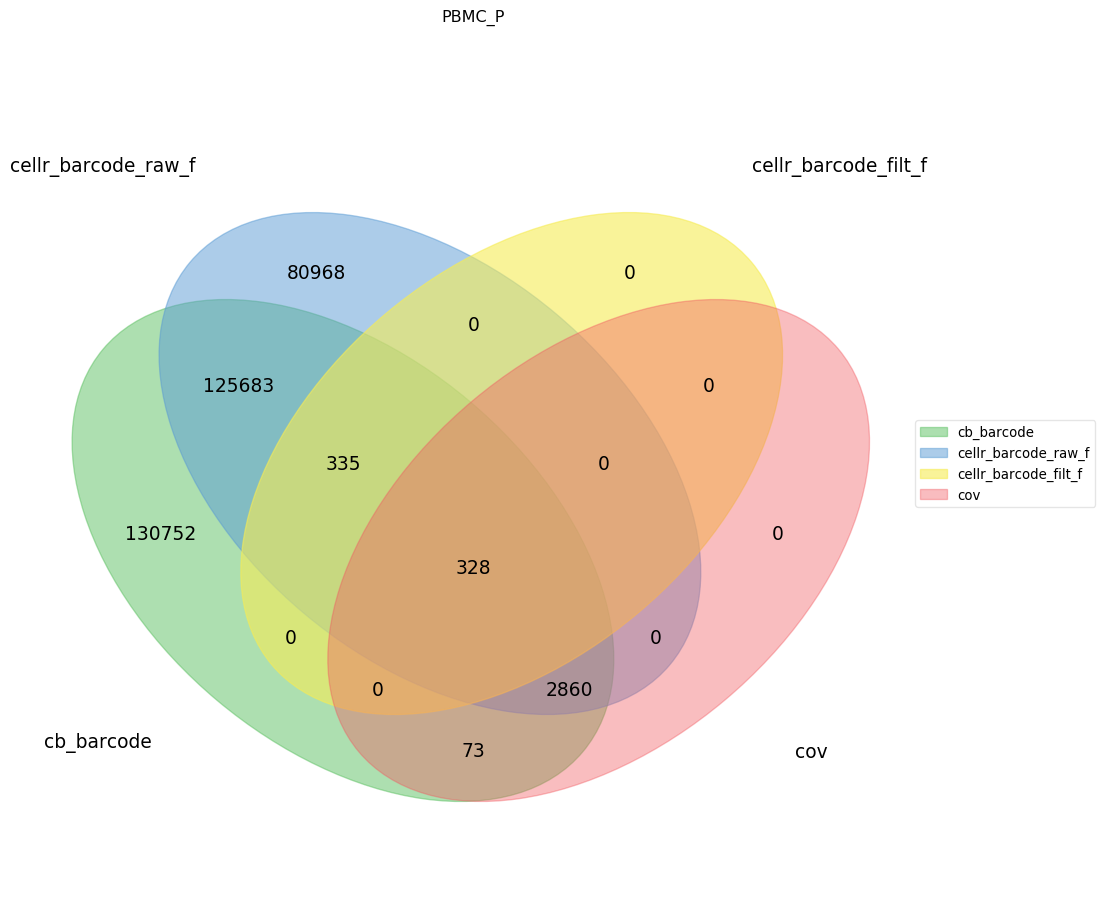

<Figure size 432x288 with 0 Axes>

In [7]:
%matplotlib inline
for ind,val in samples.iterrows():
    raw_bc_matrix = pd.read_csv(val['cellr_barcode_raw_f'],sep='\t', header=None)
    filt_bc_matrix = pd.read_csv(val['cellr_barcode_filt_f'],sep='\t', header=None)
    CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs = pickle.load(open(val["cb_barcode_f"],'rb'))
    cov_df = pd.read_csv(val["cov_f"],header=None)
    cov_df.columns = ["Pos","Cell", "Coverage"]
    cov_df["Cell"] = cov_df["Cell"].apply(lambda x: x.replace(".bam",""))
    
    # Get cell as index and value is coverage
    cells_cov_df = cov_df.groupby("Cell").sum()["Coverage"].sort_values(ascending=False)
    
    # How many cell IDs from this group are in the raw and filtered barcode list
    print(cells_cov_df.loc[cells_cov_df.index.isin(filt_bc_matrix[0].values)].shape)
    
    cell_ids_dict = {'cb_barcode':list(CB_read_number.keys()), 
                     'cellr_barcode_raw_f': raw_bc_matrix[0].values, 
                     'cellr_barcode_filt_f':filt_bc_matrix[0].values, 
                     'cov': cells_cov_df.index.values} 
    
    labels = venn.get_labels(list(cell_ids_dict.values()), fill=['number'])

    fig, ax = venn.venn4(labels, names=list(cell_ids_dict.keys()),)
    plt.title(val['sample'])
    plt.show()
    plt.savefig(samples.at[ind,"venn_out_f"])

In [11]:
# count = 0
# CB_read_number_filt = {}
# old_CB_read_number = CB_read_number.copy()
# for x in a[0].values:
#     if x not in set(CB_read_number.keys()):
#         count += 1
#         print(x)
#         print('here')
#     else:
#         CB_read_number_filt[x] = CB_read_number[x]
        
# CB_read_number = CB_read_number_filt.copy()
# print(f"Number of missing barcodes in CB but present in filtered: {count}")
# print(f"Number of cells after using cellranger cell filter: {len(CB_read_number_filt)}")

### Only the barcode raw, filtered, and CB 

(735,)


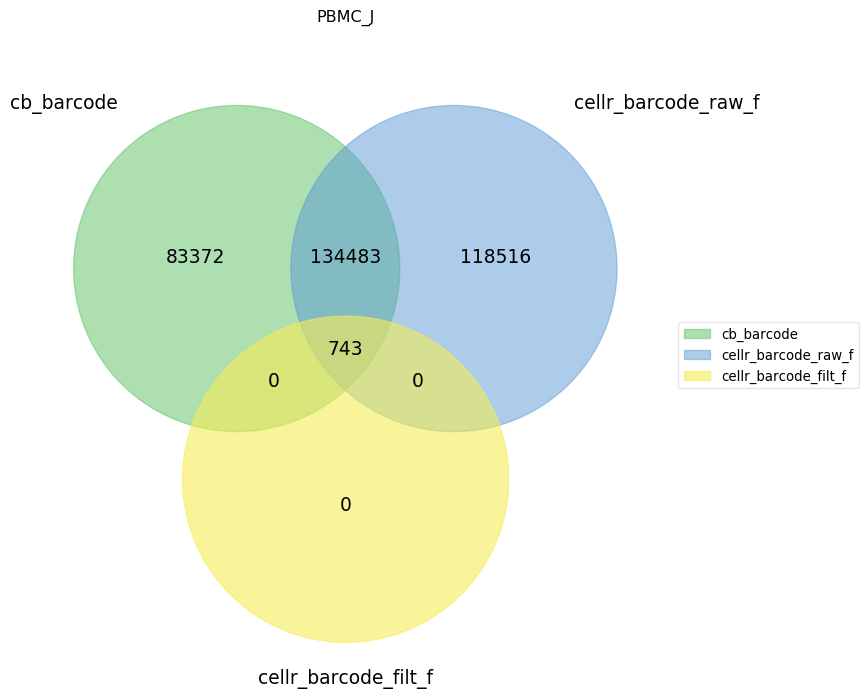

(328,)


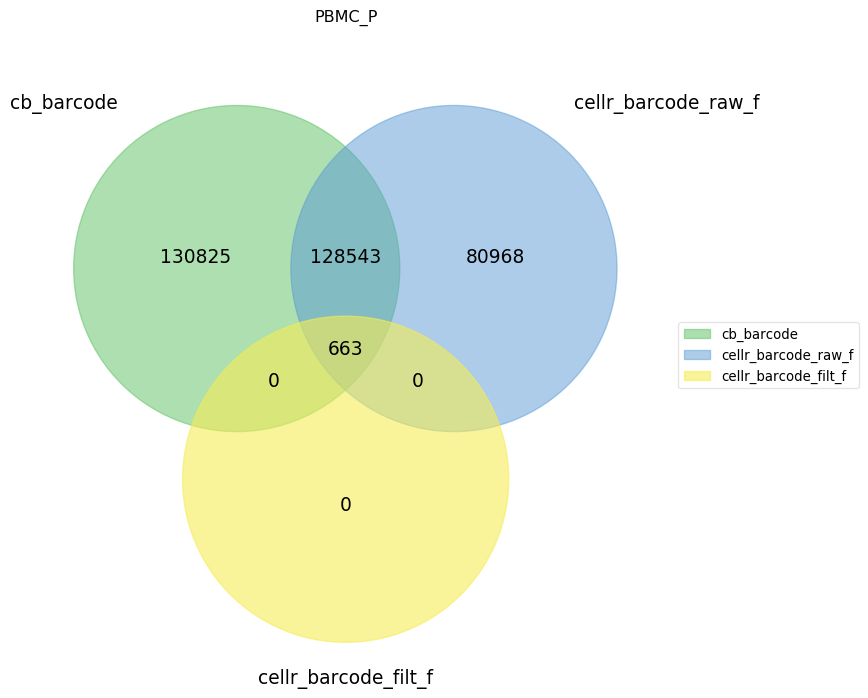

In [12]:
%matplotlib inline
for ind,val in samples.iterrows():
    raw_bc_matrix = pd.read_csv(val['cellr_barcode_raw_f'],sep='\t', header=None)
    filt_bc_matrix = pd.read_csv(val['cellr_barcode_filt_f'],sep='\t', header=None)
    CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs = pickle.load(open(val["cb_barcode_f"],'rb'))
    cov_df = pd.read_csv(val["cov_f"],header=None)
    cov_df.columns = ["Pos","Cell", "Coverage"]
    cov_df["Cell"] = cov_df["Cell"].apply(lambda x: x.replace(".bam",""))
    
    # Get cell as index and value is coverage
    cells_cov_df = cov_df.groupby("Cell").sum()["Coverage"].sort_values(ascending=False)
    
    # How many cell IDs from this group are in the raw and filtered barcode list
    print(cells_cov_df.loc[cells_cov_df.index.isin(filt_bc_matrix[0].values)].shape)
    
    cell_ids_dict = {'cb_barcode':list(CB_read_number.keys()), 
                     'cellr_barcode_raw_f': raw_bc_matrix[0].values, 
                     'cellr_barcode_filt_f':filt_bc_matrix[0].values, } 
    
    labels = venn.get_labels(list(cell_ids_dict.values()), fill=['number'])

    fig, ax = venn.venn3(labels, names=list(cell_ids_dict.keys()),)
    plt.title(val['sample'])
    plt.show()

(2233,)


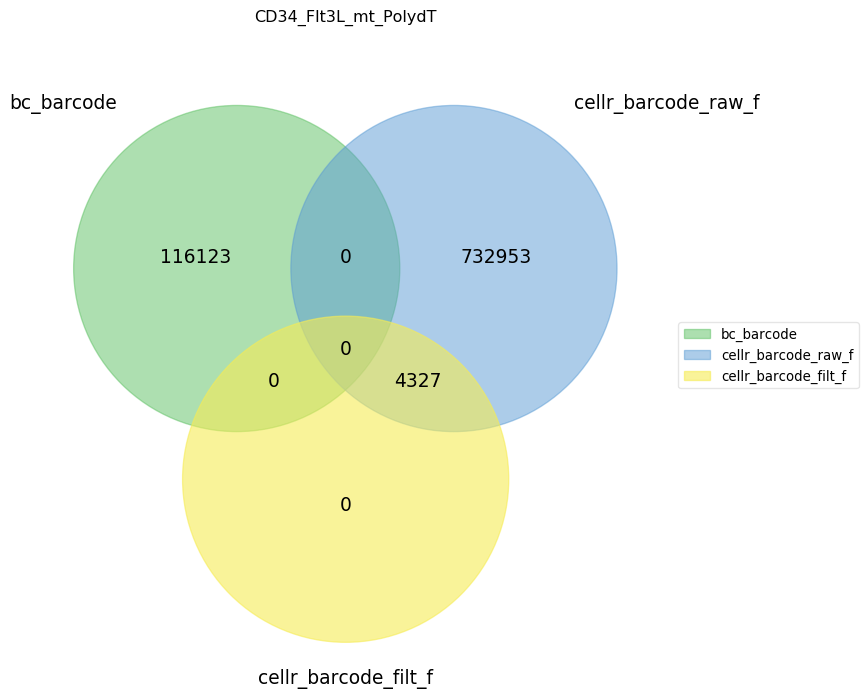

(4100,)


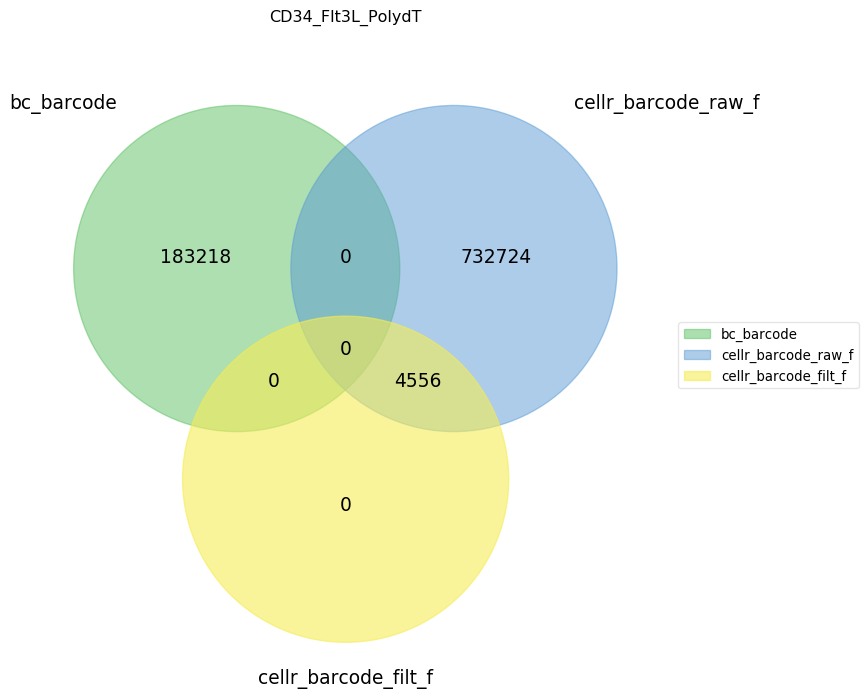

(833,)


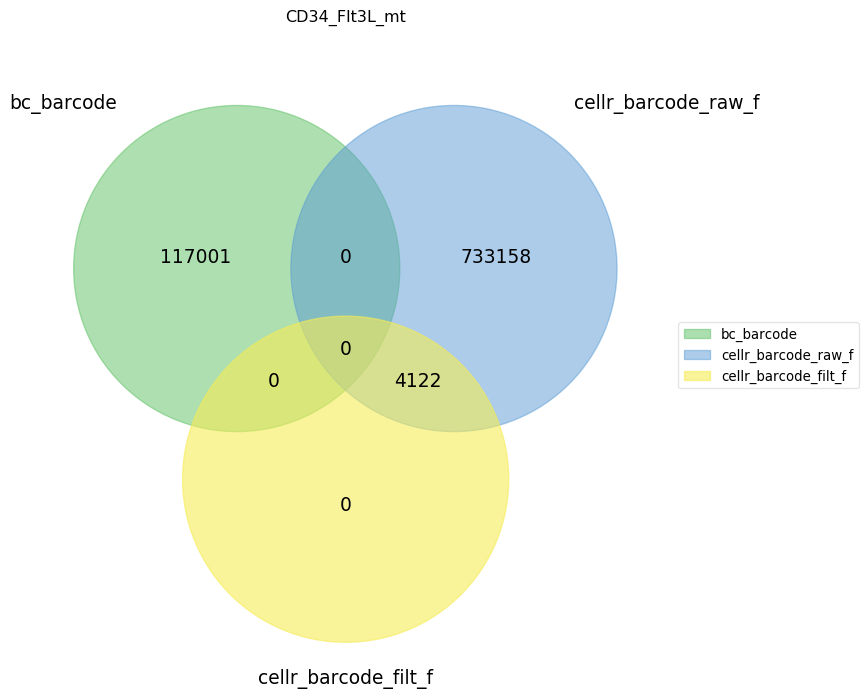

(848,)


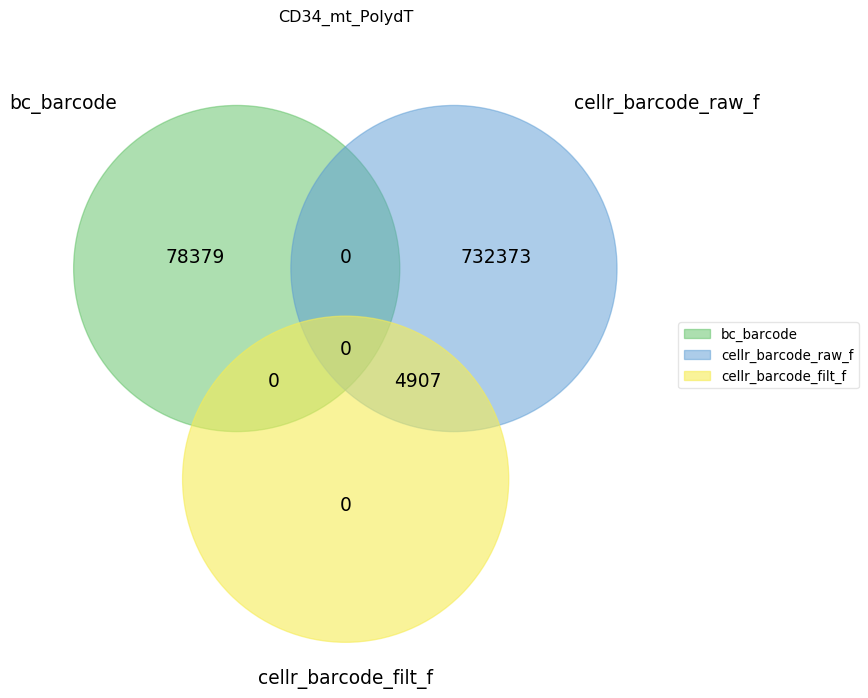

(163,)


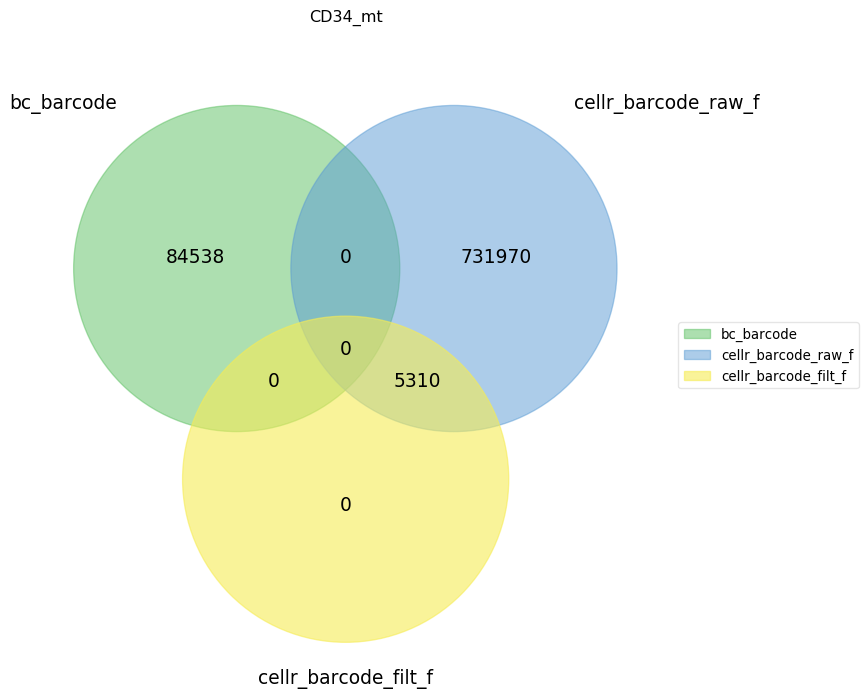

(48,)


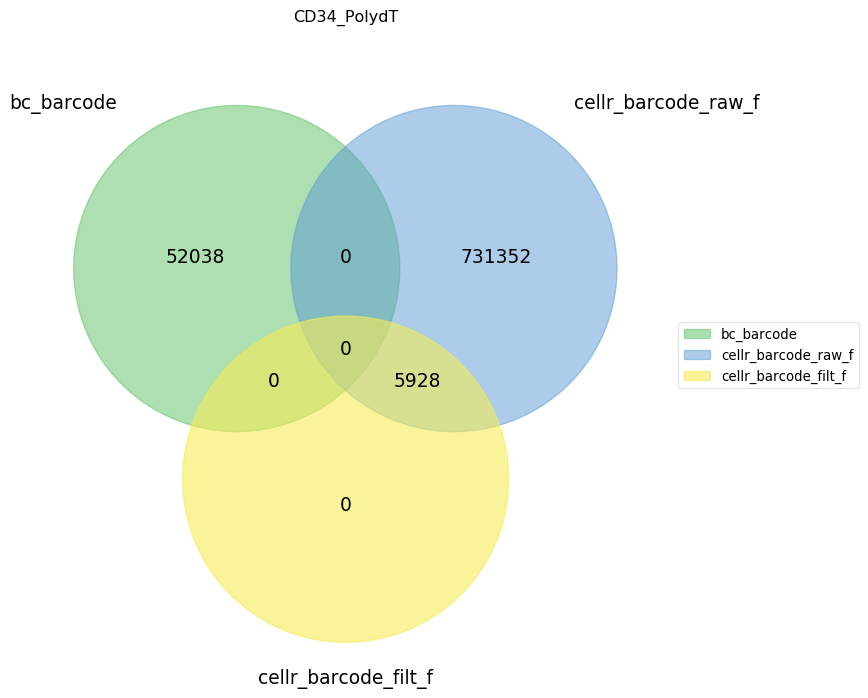

(180,)


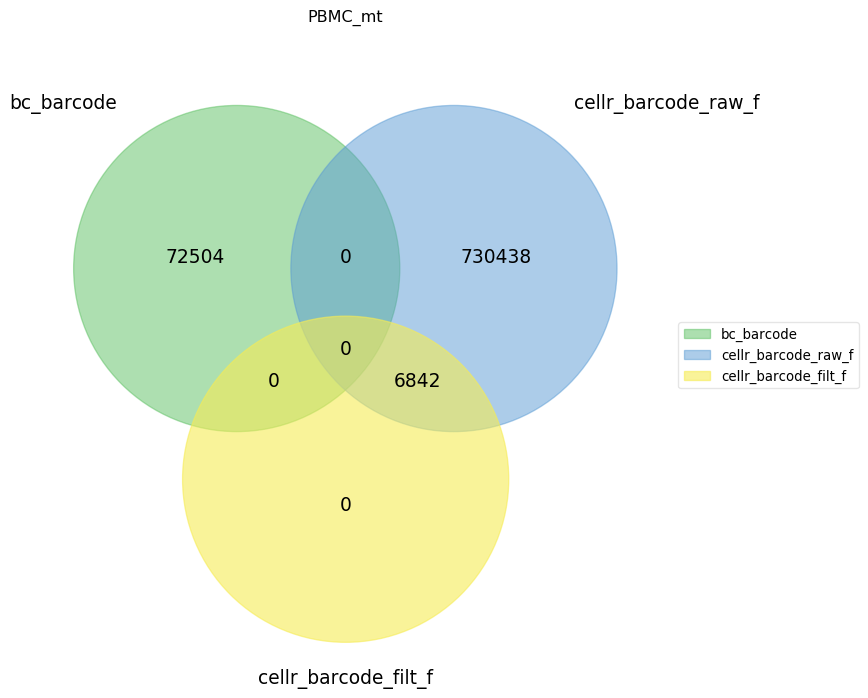

(200,)


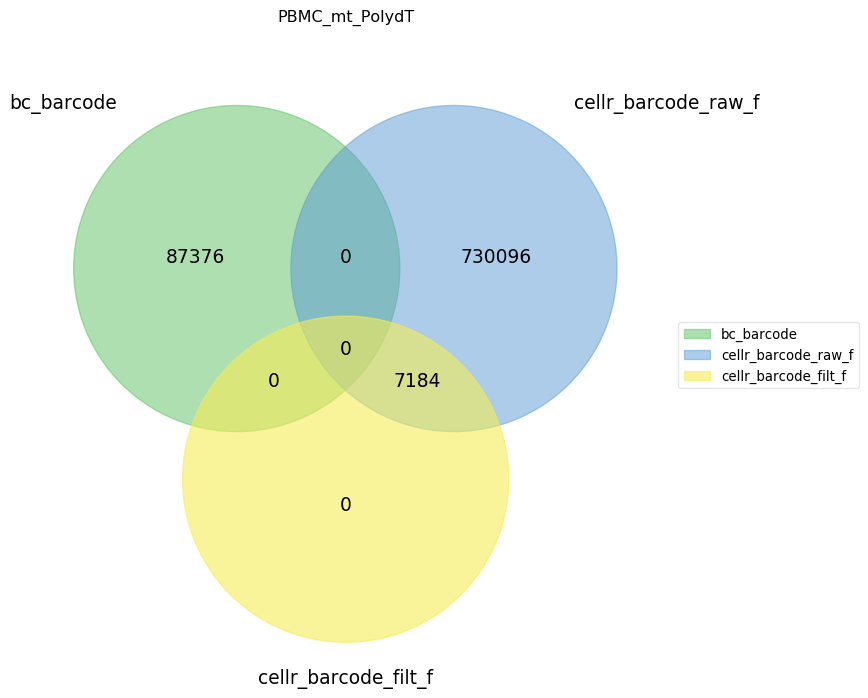

In [18]:
%matplotlib inline
for ind,val in samples.iterrows():
    raw_bc_matrix = pd.read_csv(val['cellr_barcode_raw_f'],sep='\t', header=None)
    filt_bc_matrix = pd.read_csv(val['cellr_barcode_filt_f'],sep='\t', header=None)
    CR_read_number,CB_read_number,BC_read_number, barcodes, corrected_barcodes, barcode_pairs = pickle.load(open(val["cb_barcode_f"],'rb'))
    cov_df = pd.read_csv(val["cov_f"],header=None)
    cov_df.columns = ["Pos","Cell", "Coverage"]
    cov_df["Cell"] = cov_df["Cell"].apply(lambda x: x.replace(".bam",""))
    
    # Get cell as index and value is coverage
    cells_cov_df = cov_df.groupby("Cell").sum()["Coverage"].sort_values(ascending=False)
    
    # How many cell IDs from this group are in the raw and filtered barcode list
    print(cells_cov_df.loc[cells_cov_df.index.isin(filt_bc_matrix[0].values)].shape)
    
    cell_ids_dict = {'bc_barcode':list(CR_read_number.keys()), 
                     'cellr_barcode_raw_f': raw_bc_matrix[0].values, 
                     'cellr_barcode_filt_f':filt_bc_matrix[0].values, } 
    
    labels = venn.get_labels(list(cell_ids_dict.values()), fill=['number'])

    fig, ax = venn.venn3(labels, names=list(cell_ids_dict.keys()),)
    plt.title(val['sample'])
    plt.show()

In [20]:
cells_cov_df

Cell
ACAAGCTCATCATGTG-1    60814670
TCCATCGTCGCAACTA-1    20391483
TACGCCTCACATAAAG-1    17925125
ACTACCCCACTCAAGT-1    17015526
TTCAACTGTTTCCTAT-1    16526323
                        ...   
TCAAGACAGATCGAGC-1        4524
AACATCGAGTACAACA-1        4423
TTTGCGCTCCGTTTCG-1        4407
GCTTGCTCACGGCCAT-1        4011
CAGTGCGCATTACCTT-1        3796
Name: Coverage, Length: 3261, dtype: int64

In [30]:
print(cells_cov_df.shape)
print(cells_cov_df.loc[cells_cov_df.index.isin(raw_bc_matrix[0].values)].shape)

(3261,)
(3188,)


(array([1.922e+03, 7.310e+02, 1.620e+02, 6.100e+01, 1.600e+01, 1.400e+01,
        3.200e+01, 1.900e+02, 5.900e+01, 1.000e+00]),
 array([3.5793262 , 3.99979442, 4.42026263, 4.84073085, 5.26119906,
        5.68166728, 6.10213549, 6.52260371, 6.94307192, 7.36354014,
        7.78400835]),
 <a list of 10 Patch objects>)

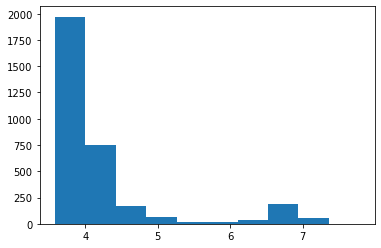

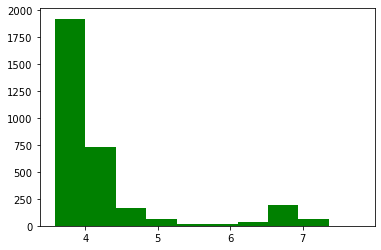

In [28]:
%matplotlib inline
f = plt.figure()
plt.hist(np.log10(cells_cov_df))
f = plt.figure()
plt.hist(np.log10(cells_cov_df.loc[cells_cov_df.index.isin(raw_bc_matrix[0].values)]), color='g')